In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Regression model

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



from sklearn.ensemble import VotingRegressor, StackingRegressor


#metrices

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("laptopPrice.csv")

In [ ]:
!pip install ydata_profiling
from ydata_profiling import ProfileReport
profile= ProfileReport(df,title="Laptop Prediction",explorative=True)
profile.to_file("ydata.html")

In [ ]:
df.columns

In [ ]:
df

In [ ]:
df.drop(columns=['Unnamed: 0.1','Unnamed: 0'],inplace=True)

In [ ]:
df.corr(numeric_only=True)['price'].sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
X=df.drop('price',axis=1)
y=df['price']

In [ ]:
numeric_features = X.select_dtypes(include = ['int64','float64']).columns
categorical_features = X.select_dtypes(include = ['object']).columns

#for numerical features

num_transformer = Pipeline (
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_transformer = Pipeline( steps = [
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
] )

#combine them
preprocessor = ColumnTransformer(
    transformers= [
        ('num',num_transformer,numeric_features),
        ('cat',cat_transformer,categorical_features)
    ]
    )

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state=42)

In [ ]:
#base learner

reg_lr = LinearRegression()
reg_rf = RandomForestRegressor( n_estimators=100, random_state=42 )
reg_gb = GradientBoostingRegressor( n_estimators=100 , random_state=42 )

#Voting regressor

voting_reg = VotingRegressor(
    estimators= [
        ('lr', reg_lr),
        ('rf',reg_rf),
        ('gb', reg_gb)
    ]
)
#stacking

stacking_reg = StackingRegressor(
    estimators= [
        ('rf',reg_rf),
        ('gb', reg_gb)
    ],
    final_estimator= Ridge() #the meta learner
)
#dictionary of all model

model_to_train = {
    'Linear Regression' : reg_lr,
    'Random Forest' : reg_rf,
    'Gradient Boosting': reg_gb,
    'Voting Ensemble ' : voting_reg,
    'Stacking Ensemble ' : stacking_reg

}


In [ ]:
#training & Evaluation

result = []

for name , model in model_to_train.items():
  #create full pipeline with preprocessor
  pipe = Pipeline(
      [
          ('preprocessor', preprocessor),
          ('model',model)
      ]
  )

  #train

  pipe.fit(X_train,y_train)

  #predict

  y_pred = pipe.predict(X_test)

  #Evaluate

  r2 = r2_score(y_test,y_pred)
  rmse = np.sqrt(mean_squared_error(y_test,y_pred))
  mae = mean_absolute_error(y_test,y_pred)

  result.append({
      "Model": name,
      "R2 Score" :r2,
      "RMSE": rmse,
      "MAE" : mae
  })

results_df = pd.DataFrame(result).sort_values("R2 Score", ascending=False)

print(results_df)

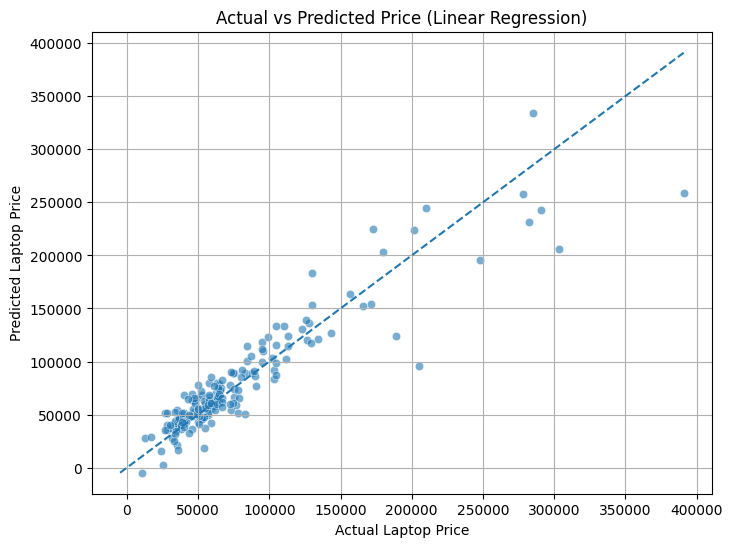

In [36]:
# Best model already selected & trained
final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model_obj)
])

final_pipe.fit(X_train, y_train)
y_final_pred = final_pipe.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))

sns.scatterplot(x=y_test, y=y_final_pred, alpha=0.6)

# perfect prediction line
min_val = min(y_test.min(), y_final_pred.min())
max_val = max(y_test.max(), y_final_pred.max())

plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel("Actual Laptop Price")
plt.ylabel("Predicted Laptop Price")
plt.title(f"Actual vs Predicted Price ({best_model_name})")

plt.grid(True)
plt.show()
